In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


# 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터로더 구성


In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


def load_data(train_data, test_data, num_words=10000):
    # 데이터의 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

    # NaN 결측치 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)#토큰화
        temp_X = [word for word in temp_X if not word in stopwords]#불용어 제거
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 모델 구성을 위한 데이터 분석 및 가공

## 시각화 하여 문장의 최대 길이를 확인해보기로 한다

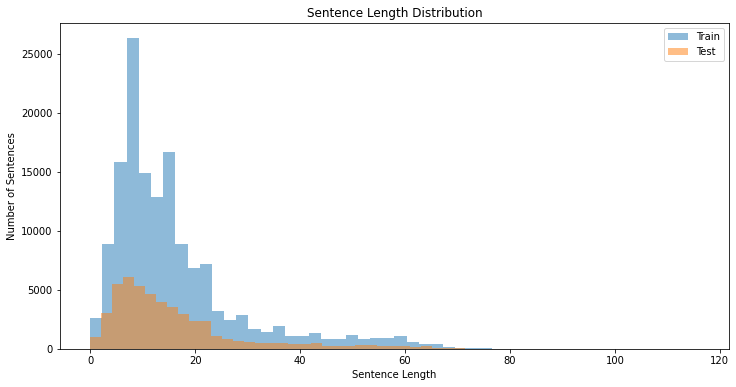

In [6]:
import matplotlib.pyplot as plt

# 각 문장의 길이를 계산
train_lengths = [len(sentence) for sentence in X_train]
test_lengths = [len(sentence) for sentence in X_test]

# 문장 길이 분포 시각화
plt.figure(figsize=(12, 6))
plt.hist(train_lengths, bins=50, alpha=0.5, label='Train')
plt.hist(test_lengths, bins=50, alpha=0.5, label='Test')
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')
plt.legend()
plt.show()

**40을 넘어서면 거의 값이 없는걸로 보여진다. 보통 문장의 95%정도를 포함한 범위로 설정한다고 하니 40정도로 설정하면 되지않을까 싶지만 자세한 값으로 표준편차를 이용해보기로한다.**

### 자세한 값도 확인해본다


In [7]:
print('train문장길이 평균 : ', np.mean(train_lengths))
print('train문장길이 최대 : ', np.max(train_lengths))
print('train문장길이 표준편차 : ', np.std(train_lengths))
print('test문장길이 평균 : ', np.mean(test_lengths))
print('test문장길이 최대 : ', np.max(test_lengths))
print('test문장길이 표준편차 : ', np.std(test_lengths))


# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens_train = np.mean(train_lengths) + 2 * np.std(train_lengths)
max_tokens_test= np.mean(test_lengths) + 2 * np.std(test_lengths)
print('max_tokens_train : ', int(max_tokens_train))
print('max_tokens_test : ', int(max_tokens_test))
max_len = int(max_tokens_train)+10
print('pad_sequences maxlen : ', max_len)
print(f'전체 문장의 {np.sum(train_lengths < max_tokens_train+10) / len(train_lengths)}%가 maxlen 설정값 이내에 포함됩니다. ')




train문장길이 평균 :  15.98170773419436
train문장길이 최대 :  116
train문장길이 표준편차 :  12.82473766384545
test문장길이 평균 :  15.932807128181134
test문장길이 최대 :  105
test문장길이 표준편차 :  12.899346084223861
max_tokens_train :  41
max_tokens_test :  41
pad_sequences maxlen :  51
전체 문장의 0.9632102447633771%가 maxlen 설정값 이내에 포함됩니다. 


**test와 train모두 표준편차가 41로 동일하다. 93퍼센트정도를 차지한다고하는데 95퍼센트를 넘기고 싶어 10의 길이를 추가해줬다**

## 이후 패딩을 진행한다.

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


# 패딩 추가
X_train_padded = pad_sequences(X_train, maxlen=max_len, padding='pre')
X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='pre')

# 결과 확인
print(X_train_padded[:3])
print(X_test_padded[:3])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0   32
    74  919    4    4   39  228   20   33  748]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0 1028    4   11  519  549  687    5  120
     4   70 1639   52  925 1006   15   44  391]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   24  205    3]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0  

**그리고 pre가 더 좋다는 말에 post가 아닌pre로 지정하였다.**
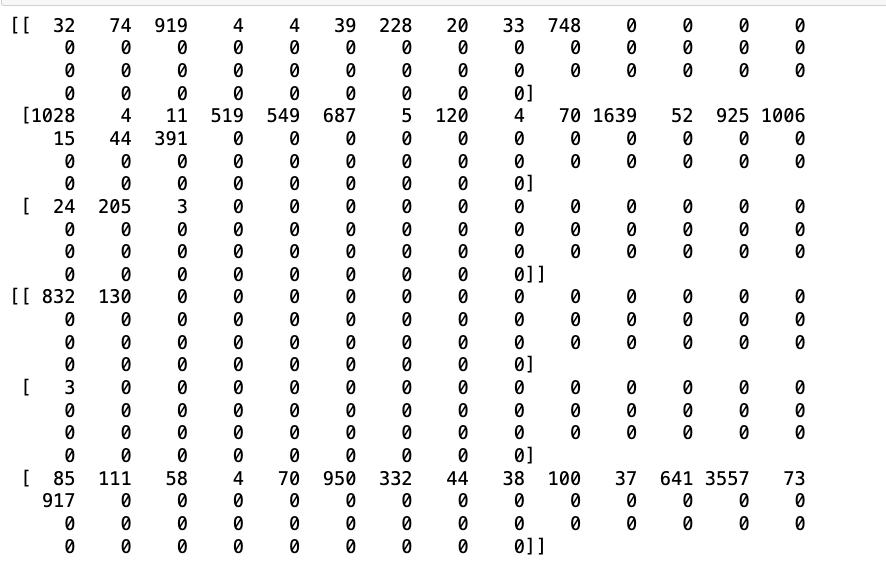
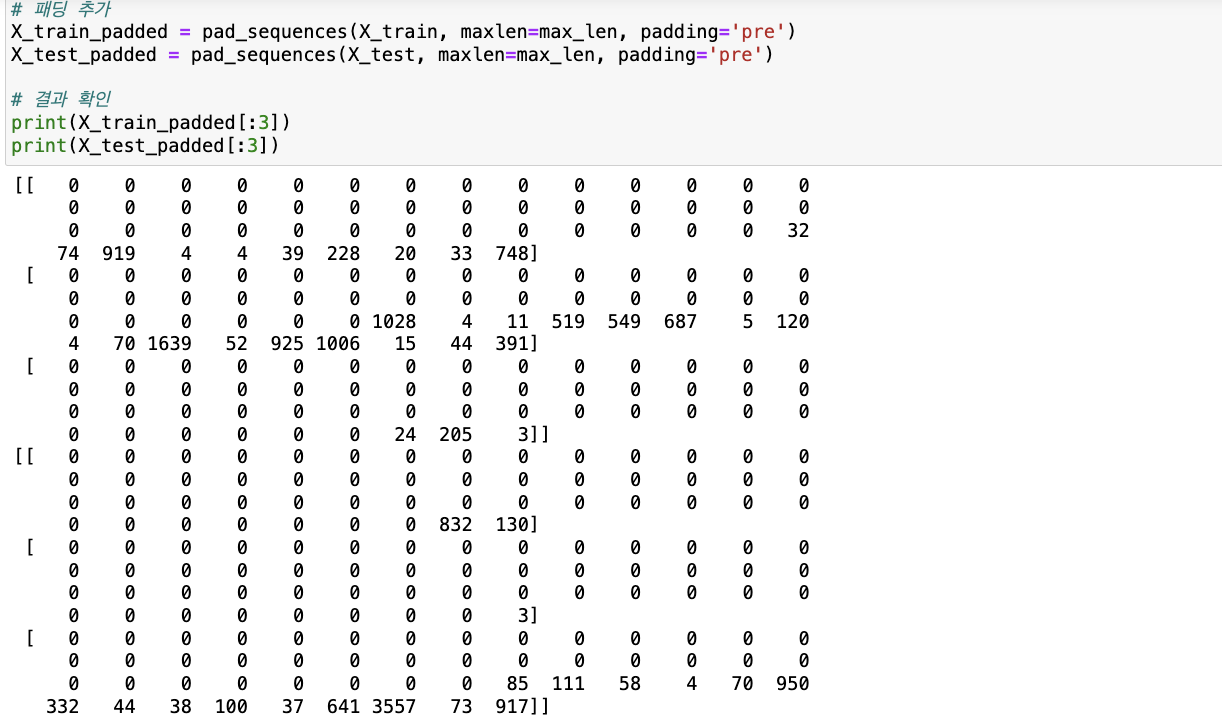

# 모델 구성 및 validation set 구성

### LSTM, GRU, CNN으로 테스트를 진행
**옵티마이저는 아담으로 설정하고 LSTM과 GRU의 층은 32로 임베딩 차원은 100으로 설정했다.**

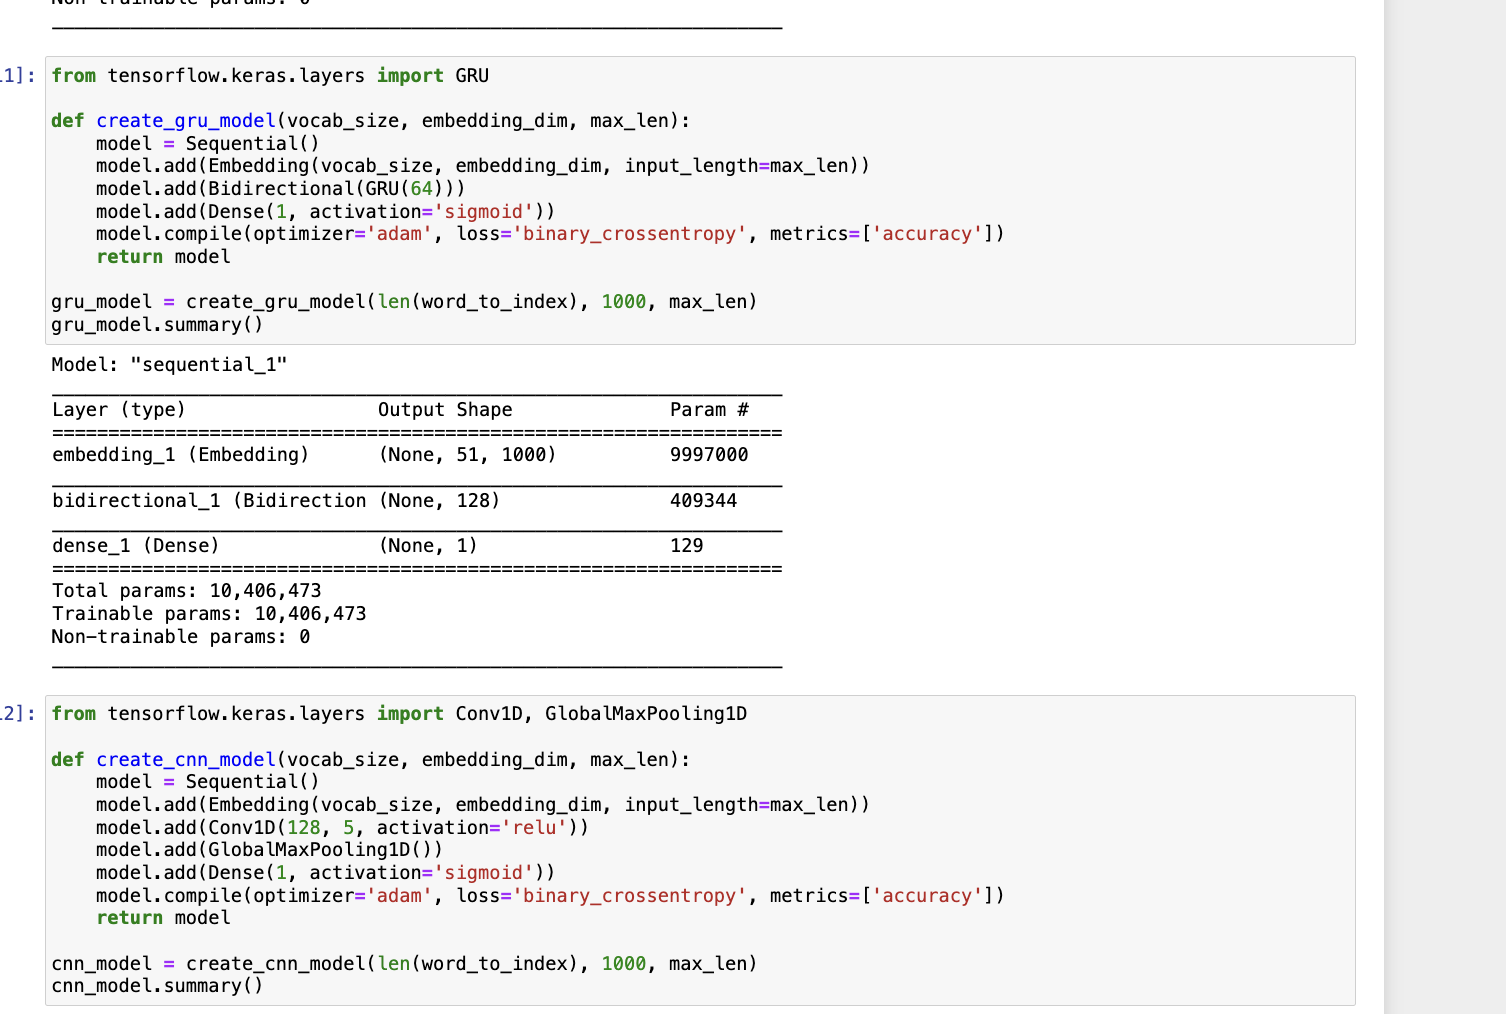

기본으로 2번의 파라미터 변경과 애폭 변경 실험을 진행하고 이후드롭아웃과 콜백을 진행하기로한다.

In [9]:
from sklearn.model_selection import train_test_split

# Train set과 Validation set 나누기
X_train_padded, X_val_padded, y_train, y_val = train_test_split(X_train_padded, y_train, test_size=0.2, random_state=42)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

def create_lstm_model(vocab_size, embedding_dim, max_len):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

lstm_model = create_lstm_model(len(word_to_index), 1000, max_len)
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 51, 1000)          9997000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               545280    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 10,542,409
Trainable params: 10,542,409
Non-trainable params: 0
_________________________________________________________________


In [11]:
from tensorflow.keras.layers import GRU

def create_gru_model(vocab_size, embedding_dim, max_len):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(Bidirectional(GRU(64)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


gru_model = create_gru_model(len(word_to_index), 1000, max_len)
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 51, 1000)          9997000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               409344    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 10,406,473
Trainable params: 10,406,473
Non-trainable params: 0
_________________________________________________________________


In [12]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

def create_cnn_model(vocab_size, embedding_dim, max_len):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


cnn_model = create_cnn_model(len(word_to_index), 1000, max_len)
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 51, 1000)          9997000   
_________________________________________________________________
conv1d (Conv1D)              (None, 47, 128)           640128    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 10,637,257
Trainable params: 10,637,257
Non-trainable params: 0
_________________________________________________________________


In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 콜백 설정
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss'),
    ModelCheckpoint('model.h5', save_best_only=True, monitor='val_loss')
]

# LSTM 모델 훈련
print("LSTM Start")
history_lstm = lstm_model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_data=(X_val_padded, y_val), callbacks=callbacks)

# GRU 모델 훈련
print("GRU Start")
history_gru = gru_model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_data=(X_val_padded, y_val), callbacks=callbacks)

# CNN 모델 훈련
print("CNN Start")
history_cnn = cnn_model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_data=(X_val_padded, y_val), callbacks=callbacks)
print("LSTM Start")


LSTM Start
Epoch 1/10
1828/1828 [==============================] - 32s 15ms/step - loss: 0.3680 - accuracy: 0.8360 - val_loss: 0.3193 - val_accuracy: 0.8634
Epoch 2/10
1828/1828 [==============================] - 27s 15ms/step - loss: 0.2792 - accuracy: 0.8828 - val_loss: 0.3113 - val_accuracy: 0.8653
Epoch 3/10
1828/1828 [==============================] - 26s 14ms/step - loss: 0.2305 - accuracy: 0.9052 - val_loss: 0.3257 - val_accuracy: 0.8649
Epoch 4/10
1828/1828 [==============================] - 27s 15ms/step - loss: 0.1896 - accuracy: 0.9235 - val_loss: 0.3796 - val_accuracy: 0.8582
Epoch 5/10
1828/1828 [==============================] - 27s 15ms/step - loss: 0.1556 - accuracy: 0.9392 - val_loss: 0.4229 - val_accuracy: 0.8595
GRU Start
Epoch 1/10
1828/1828 [==============================] - 28s 14ms/step - loss: 0.3661 - accuracy: 0.8374 - val_loss: 0.3171 - val_accuracy: 0.8638
Epoch 2/10
1828/1828 [==============================] - 25s 14ms/step - loss: 0.2764 - accuracy: 0.8848

5번째 애폭에서 학습이 중단됨
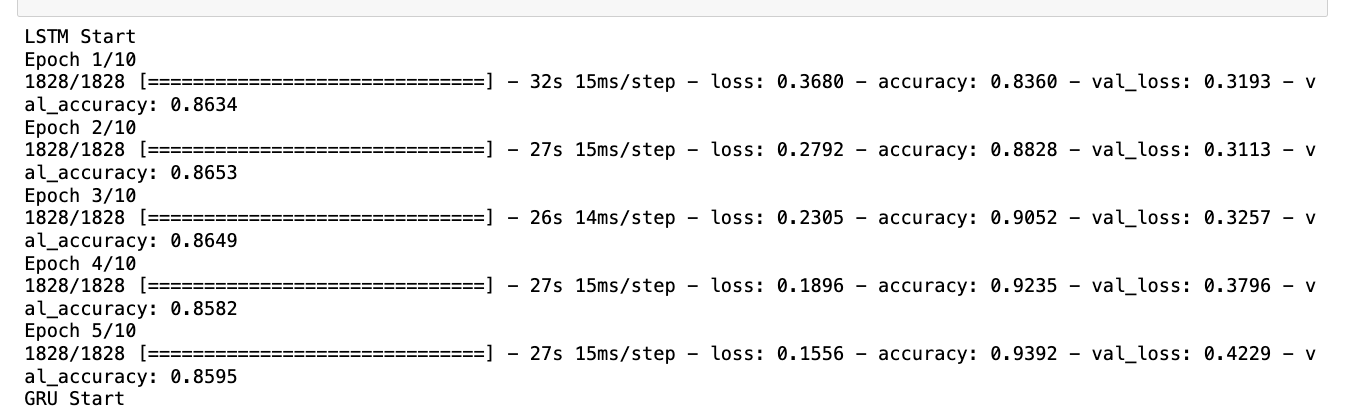

#  Loss, Accuracy 그래프 시각화

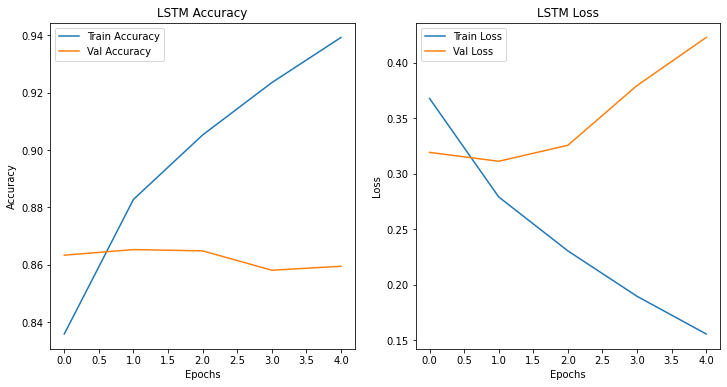

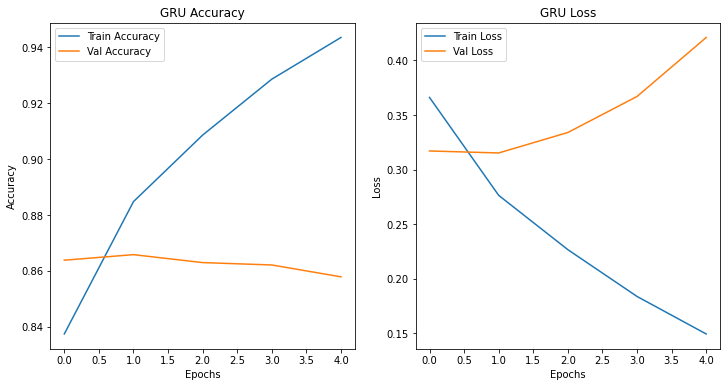

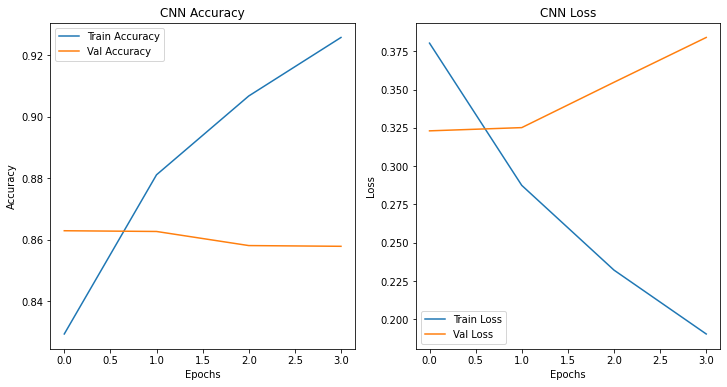

In [14]:
def plot_history(history, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# 각 모델의 학습 결과 시각화
plot_history(history_lstm, 'LSTM')
plot_history(history_gru, 'GRU')
plot_history(history_cnn, 'CNN')

## fit(X_train_padded, y_train, epochs=10, batch_size=512, validation_data=(X_val_padded, y_val))

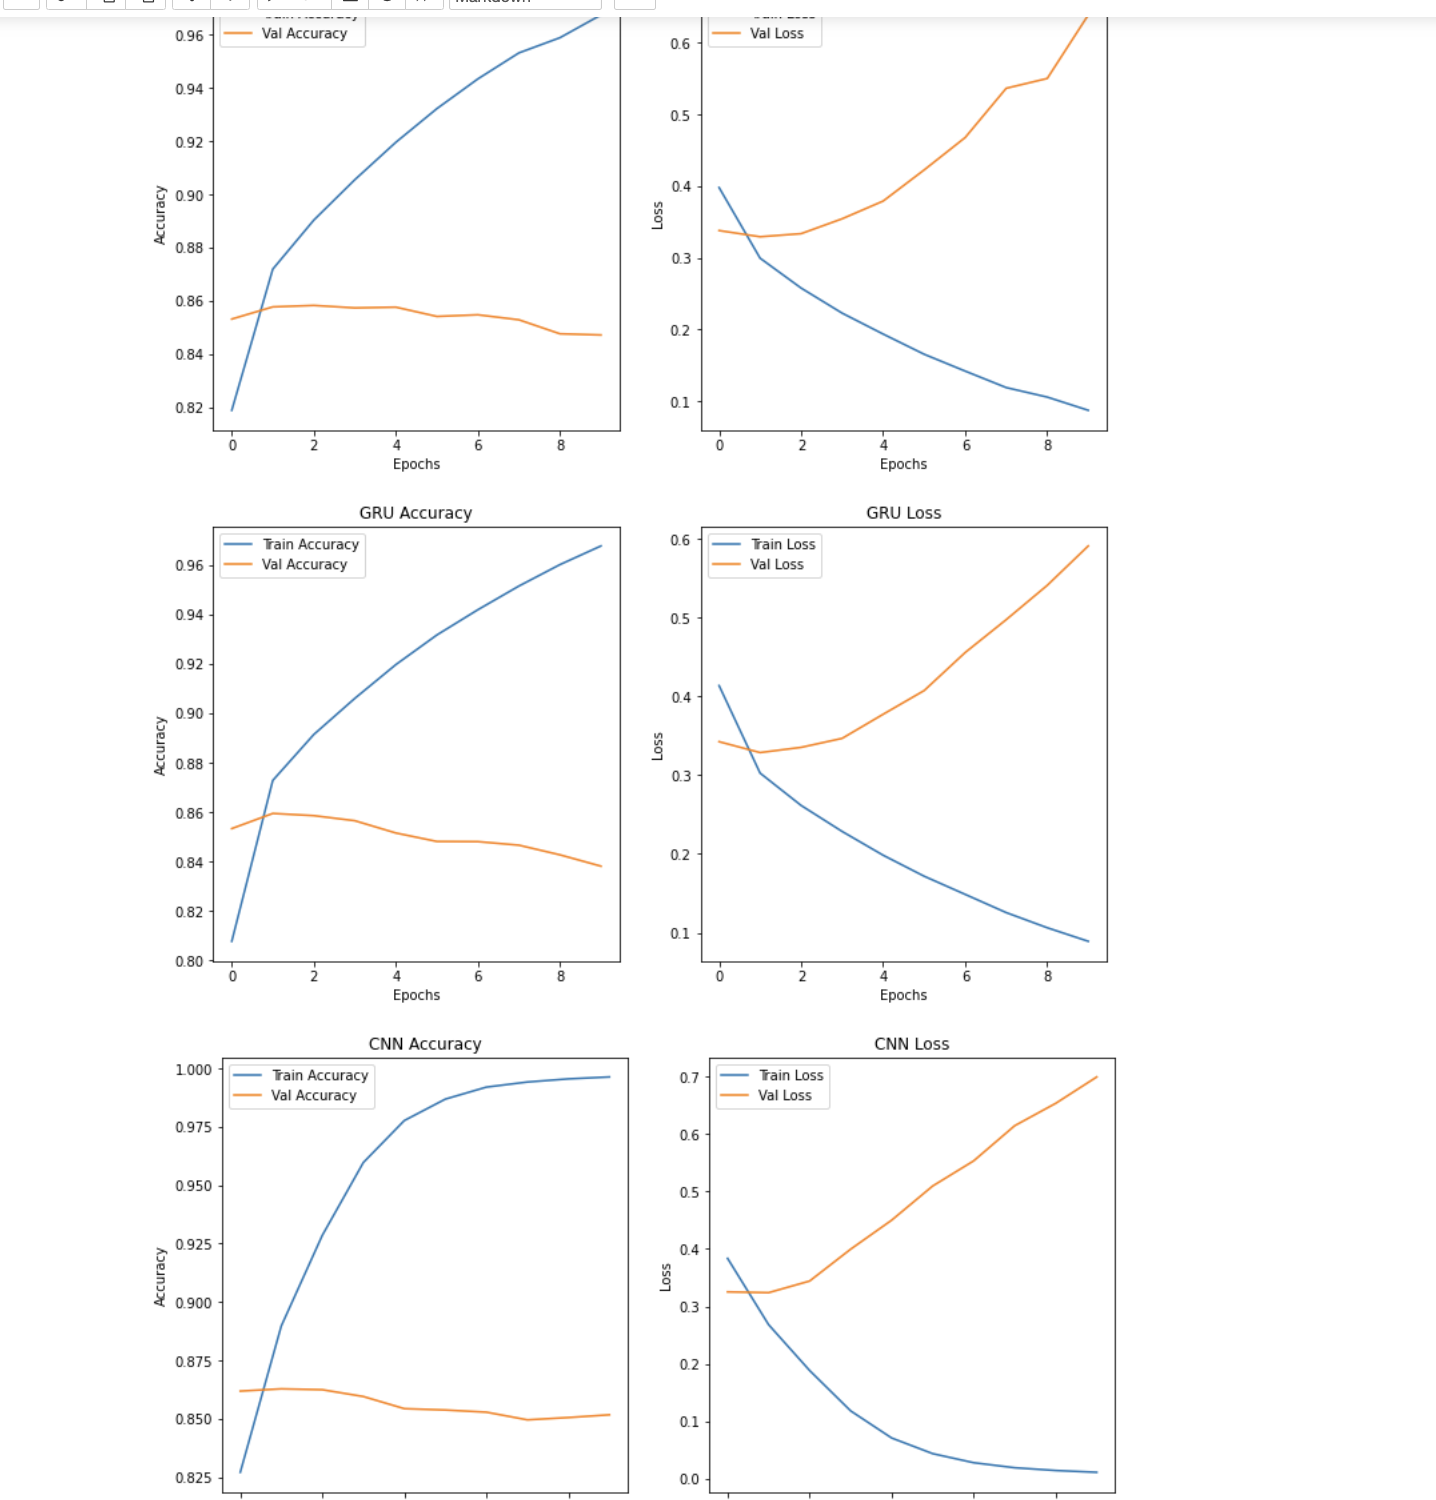

# fit(X_train_padded, y_train, epochs=10, batch_size=256, validation_data=(X_val_padded, y_val))
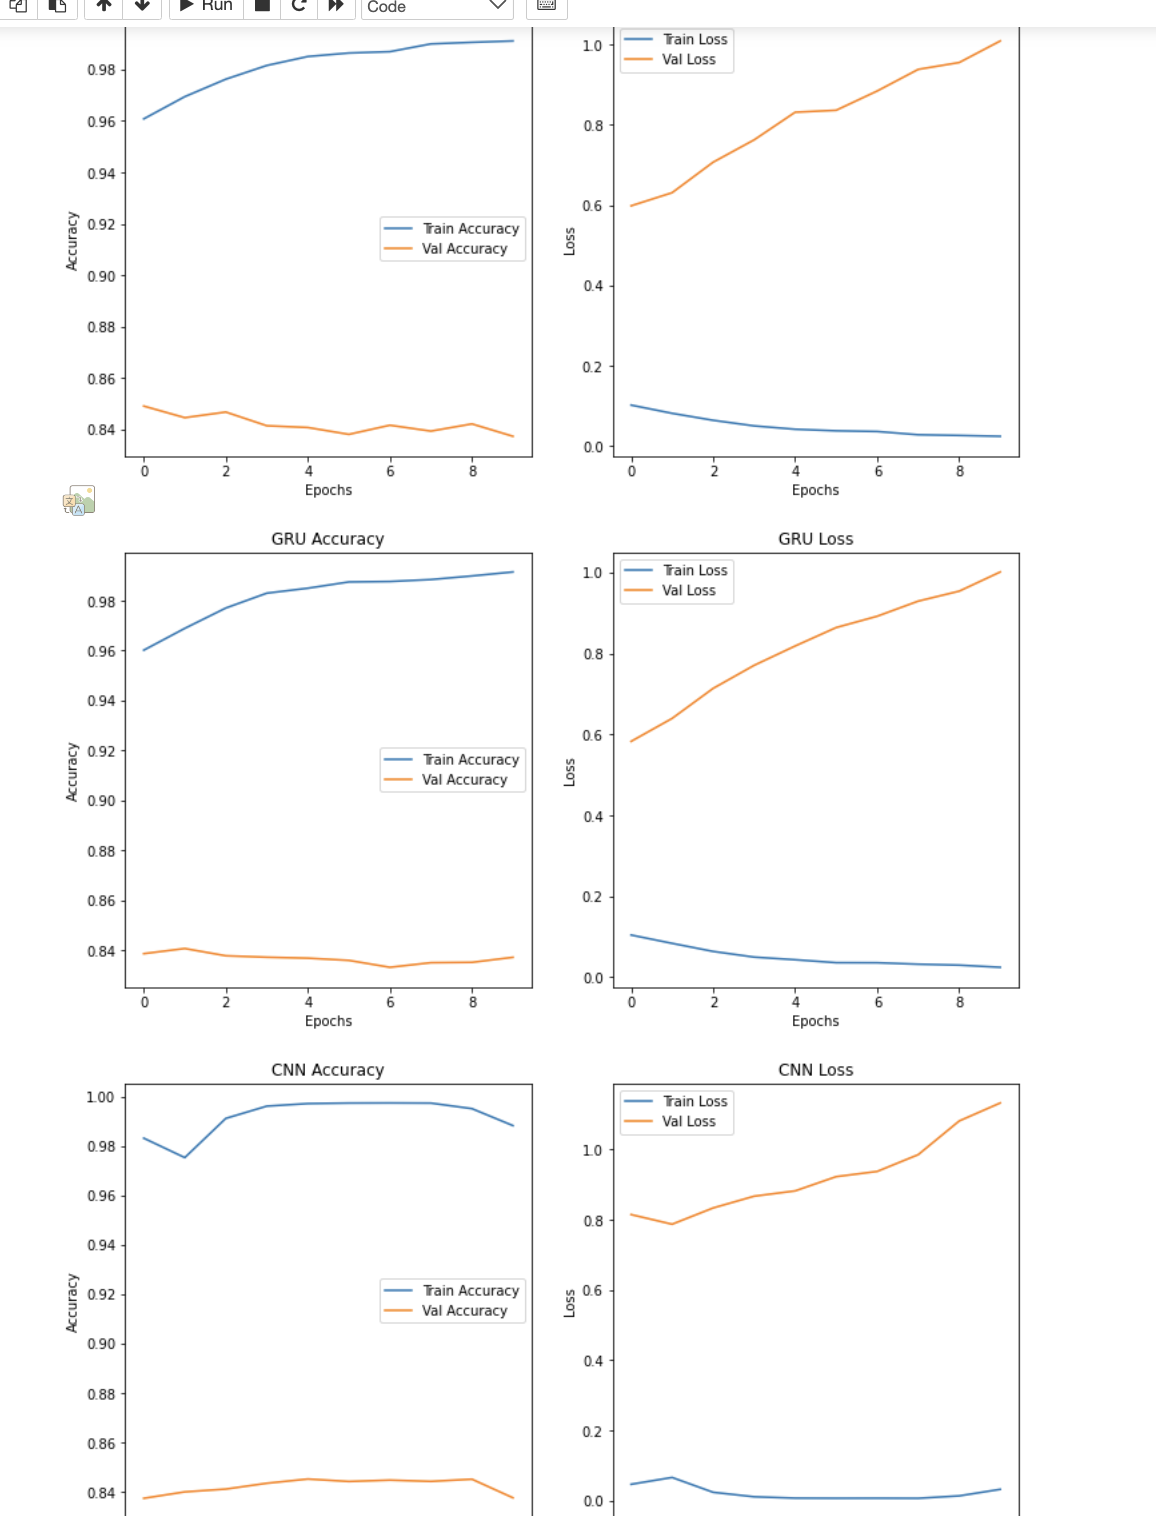
### 이미 학습을 진행한뒤 다시 진행한 부분이라 문제가 발생한듯하다.

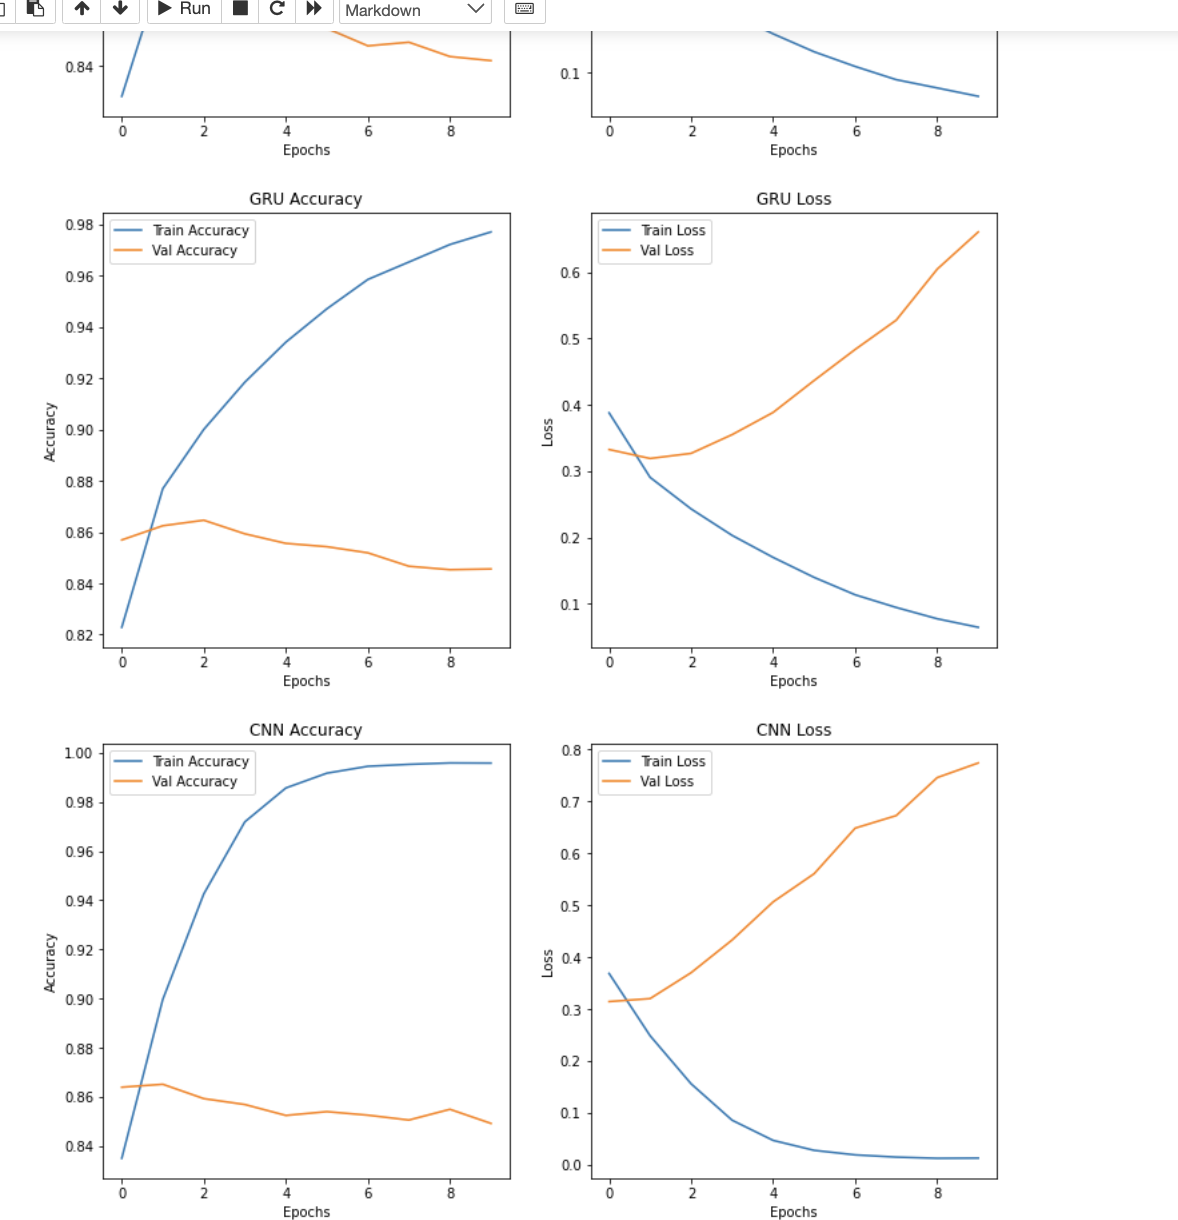
## 다시진행한 모델 핏


# 학습된 Embedding 레이어 분석

In [15]:
import os
vocab_size=len(word_to_index)
word_vector_dim = 1000

embedding_layer1 = lstm_model.layers[0]
weights1 = embedding_layer1.get_weights()[0]
print(weights1.shape)

word2vec_file_path1 = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_LSTM.txt'
f = open(word2vec_file_path1, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors1 = lstm_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors1[i, :])))))
f.close()


(9997, 1000)


In [16]:
embedding_layer2 = gru_model.layers[0]
weights2 = embedding_layer2.get_weights()[0]
print(weights2.shape)

word2vec_file_path2 = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_GRU.txt'
f = open(word2vec_file_path2, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors2 = gru_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors2[i, :])))))
f.close()


(9997, 1000)


In [17]:
embedding_layer3 = cnn_model.layers[0]
weights3 = embedding_layer3.get_weights()[0]
print(weights3.shape)

word2vec_file_path3 = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_CNN.txt'
f = open(word2vec_file_path3, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors3 = cnn_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors3[i, :])))))
f.close()


(9997, 1000)


## LSTM으로 학습한 임베딩

In [18]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors1 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path1, binary=False)
vector1 = word_vectors1['하나님']
vector1

array([-9.53381509e-02,  1.85658202e-01, -4.07650732e-02,  1.67132184e-01,
        2.27456558e-02,  1.82836726e-01, -1.62151515e-01,  7.95153752e-02,
        1.11148311e-02,  2.85022482e-02, -6.37176111e-02, -9.28115323e-02,
        5.88896461e-02,  8.26172829e-02,  6.54704273e-02, -1.61534563e-01,
        5.29341437e-02, -1.13460526e-01,  1.34012073e-01,  8.40486512e-02,
       -9.64355171e-02, -1.88944846e-01, -8.62126332e-03, -3.66891362e-02,
        6.12077815e-03, -2.63714734e-02, -1.17923751e-01, -4.50492501e-02,
        4.49482761e-02,  6.36233464e-02,  1.38323888e-01, -1.51332049e-02,
        1.23902276e-01, -1.46718532e-01, -8.90926551e-03, -9.44849104e-02,
        1.79656502e-02, -4.25518826e-02,  2.81607695e-02, -1.14654168e-01,
       -1.02467082e-01, -4.09757644e-02,  2.74094865e-02,  6.01538606e-02,
       -1.53721914e-01,  2.70771030e-02, -4.92136702e-02, -3.31258867e-03,
       -6.01770841e-02, -1.25365302e-01, -2.50487812e-02, -1.62162304e-01,
       -1.42192572e-01, -

In [19]:
word_vectors1.similar_by_word("하나님")

[('처절', 0.6044105887413025),
 ('낙원', 0.5733382105827332),
 ('살아오', 0.5674841403961182),
 ('만남', 0.567252516746521),
 ('높이', 0.5584700107574463),
 ('메인', 0.5385881662368774),
 ('유준상', 0.5243585705757141),
 ('기독교인', 0.5215351581573486),
 ('였을', 0.5210966467857361),
 ('살아남', 0.5149233937263489)]

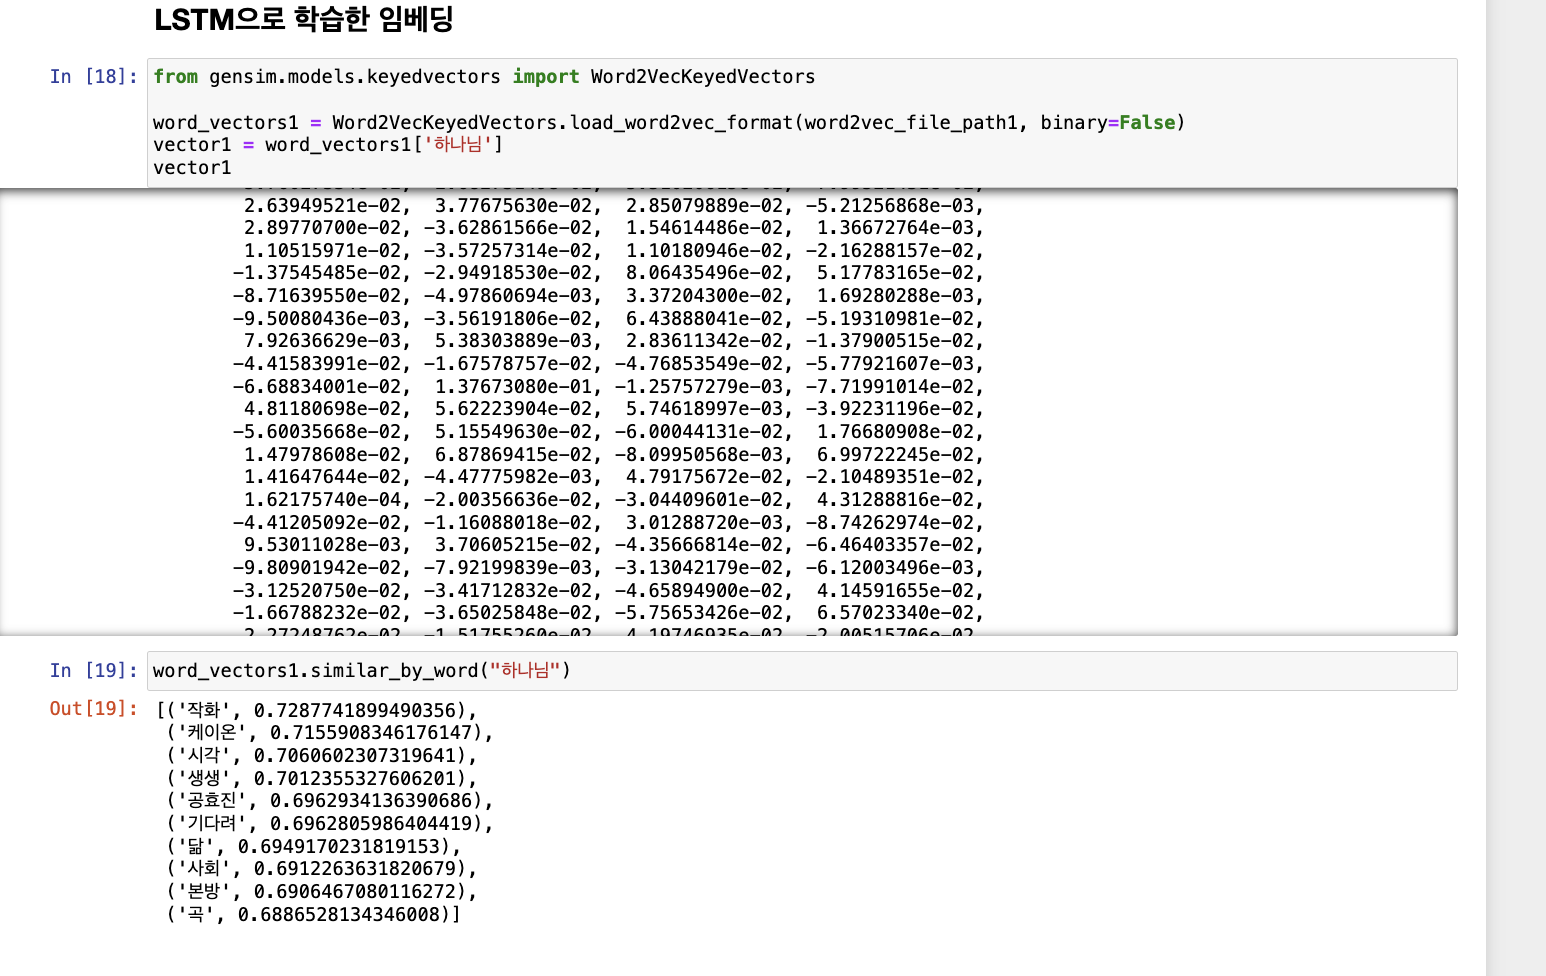

## GRU로 학습한 임베딩


In [20]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors2 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path2, binary=False)
vector2 = word_vectors2['하나님']
vector2

array([-9.92989317e-02, -1.71778519e-02,  5.29651046e-02, -1.24228254e-01,
       -8.46719965e-02, -8.61785095e-03,  1.21612124e-01, -1.76933609e-04,
        1.57096535e-02, -1.23438872e-01, -2.05569074e-01,  1.30094260e-01,
        8.83924812e-02,  1.20804563e-01, -3.86566594e-02, -1.78201869e-01,
        1.03865422e-01,  3.36813293e-02, -1.66302368e-01,  3.76771912e-02,
       -2.86741368e-02,  1.10144205e-01,  2.39542216e-01,  1.55375600e-02,
       -1.47546336e-01,  1.82274565e-01, -1.10157505e-01,  5.90713397e-02,
        1.34694234e-01, -8.82211328e-02,  1.68994352e-01,  1.25868529e-01,
        4.01165038e-02,  8.23084905e-04, -6.56355591e-03,  1.26932487e-01,
        1.29792139e-01,  1.41354695e-01, -1.46275125e-02, -2.43457314e-02,
        4.31009568e-02, -9.88940820e-02,  9.38994139e-02,  1.92966033e-02,
       -2.68993862e-02,  3.30852182e-03, -8.91224667e-02, -6.84559196e-02,
        9.48189497e-02, -5.85864671e-02,  2.35165767e-02, -1.37028426e-01,
        1.21526271e-01, -

In [21]:
word_vectors2.similar_by_word("하나님")

[('국판', 0.6345997452735901),
 ('간다고', 0.6260862946510315),
 ('핫세', 0.6154506802558899),
 ('시스템', 0.6143056750297546),
 ('자격', 0.6084177494049072),
 ('유덕화', 0.6006536483764648),
 ('제공', 0.5969041585922241),
 ('벤', 0.5854687094688416),
 ('너희', 0.5835033655166626),
 ('만날', 0.577516496181488)]

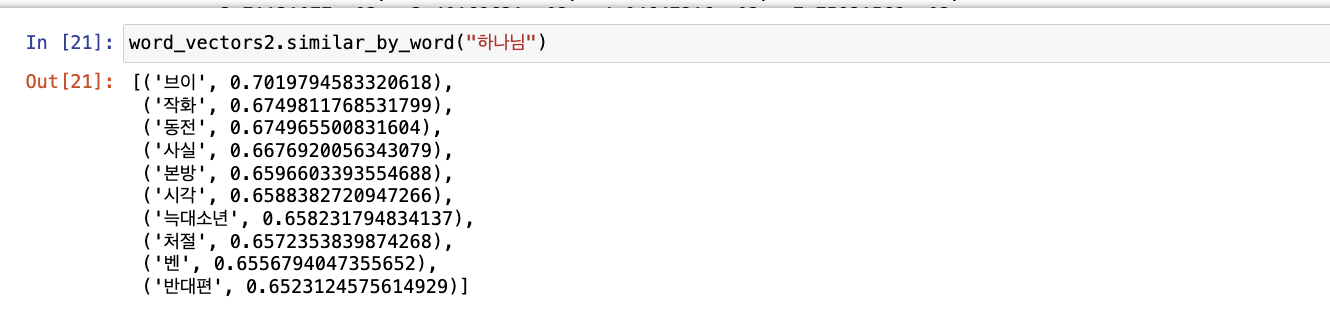
애폭을 4로 줄이고 학습한 결과 30%정도 정확도가 상승

## CNN으로 학습한 임베딩


In [22]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors3 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path3, binary=False)
vector3 = word_vectors3['하나님']
vector3

array([-3.80659215e-02,  1.34842861e-02, -1.46366209e-01,  1.77644745e-01,
       -4.65242863e-02,  3.21814083e-02,  8.85475334e-03,  3.98721844e-02,
        5.74779548e-02, -5.25703095e-02, -7.65878558e-02,  8.23281482e-02,
        3.75202224e-02,  6.15624227e-02, -8.22780095e-03,  1.07506432e-01,
       -8.66504312e-02,  3.95953916e-02, -1.05238669e-02, -4.27966416e-02,
       -1.35088339e-01, -7.96761736e-02, -6.38412759e-02,  3.90631706e-03,
       -3.70327421e-02,  1.85516421e-02,  8.04841742e-02,  9.39871892e-02,
       -6.28380626e-02, -2.23169476e-02,  6.46596551e-02, -2.68882290e-02,
       -8.56022909e-02, -1.66986510e-02, -8.24919418e-02,  1.95651632e-02,
        1.76376030e-02, -9.02241394e-02,  4.89146933e-02, -2.97841150e-02,
        3.30653861e-02, -7.48355240e-02, -3.82755958e-02,  1.72500480e-02,
        1.34238526e-01, -1.44782867e-02,  4.39530909e-02,  6.49534538e-02,
       -3.40206288e-02, -1.79930422e-02, -4.47780080e-02,  1.06766820e-01,
        1.35179624e-01, -

In [23]:
word_vectors3.similar_by_word("하나님")

[('어우러져', 0.4759572148323059),
 ('의외', 0.452399879693985),
 ('선장', 0.43403884768486023),
 ('짜임', 0.41998493671417236),
 ('탄탄', 0.41064465045928955),
 ('아픈', 0.4081355035305023),
 ('계시', 0.4073096811771393),
 ('차기', 0.40544015169143677),
 ('훌', 0.40504783391952515),
 ('새로운', 0.40440601110458374)]

# 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [24]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = '/aiffel/data/word2vec_ko.model'  # 모델 경로
word_vectors1 = Word2VecKeyedVectors.load(word2vec_file_path)
vector1 = word_vectors1.wv['하나님']
vector1

array([ 4.424972  , -1.971676  , -3.3577693 ,  0.985919  , -1.6239744 ,
       -3.701571  ,  4.8051662 , -3.1997917 , -0.37655666, -0.95965284,
       -1.1711895 ,  1.123477  , -2.4759579 ,  1.1924347 , -2.345002  ,
        1.015524  , -2.585604  , -1.2525524 ,  3.5076997 , -2.5298846 ,
       -3.7462316 , -0.6417846 , -0.94271237,  0.9382616 ,  1.9743015 ,
        2.236961  ,  2.4468725 ,  0.30499706,  0.18259983, -3.6559672 ,
       -1.1647131 ,  0.20886527, -3.8981009 ,  2.6076565 ,  1.011704  ,
        2.0507267 ,  1.1329024 ,  1.8271    ,  0.874468  ,  1.2998832 ,
       -1.1326108 ,  2.040514  ,  4.219015  ,  0.6020559 ,  1.860111  ,
        3.649302  ,  5.095837  ,  2.808689  , -1.7316184 ,  4.1809816 ,
       -1.380046  ,  2.3663368 ,  3.5156748 , -3.7773178 ,  1.6736954 ,
       -5.5935736 , -2.167975  ,  0.94765586, -0.47240534,  1.3327729 ,
        3.5992503 ,  0.78246355, -0.16258036, -3.5805469 ,  1.3015387 ,
       -4.9470925 , -1.2008098 , -1.2960266 , -0.8302401 , -1.26

In [25]:
word_vectors1.wv.similar_by_word("하나님")

[('하느님', 0.9558471441268921),
 ('그리스도', 0.8831457495689392),
 ('성령', 0.8630900979042053),
 ('그분', 0.847241997718811),
 ('말씀', 0.8182541131973267),
 ('예수', 0.8066360354423523),
 ('야훼', 0.8012031316757202),
 ('은총', 0.7909775972366333),
 ('계시', 0.7840383648872375),
 ('창조주', 0.757165789604187)]

# 회고

- 배운 점 : RNN을 제대로 처음 다뤄본것같다. 온전히 내께 된것같지는 않지만 그래도 어떤 흐름으로 진행되고 어떻게 사용하는지 정도는 배운것 같다.

- 아쉬운 점 : Word2VecKeyedVectors 를 적용하는데 생각보다 시간을 많이 사용해 다양한 값으로 테스트를 진행하지 못한것이 조금 아쉽습니다.

- 느낀 점 : 역시 기존에 학습된 모델이 성능이 우월하다...

- 어려웠던 점 : 제공되어 있는 코드를 변환해 작업한 결과 크게 어려움은 느끼지 못했지만, 초반부분에 word_to_index에 있는 패딩을 어떻게 해야할지 찾는데 조금 오래 걸렸습니다. 결국 그냥 설정을 안해도 자동으로 패딩되는걸 찾아 따로 설정하지않고 진행했습니다.